>
> # Shared rides with pricing

 ### Changes to:
 * shared.py
 * new function `pool_price.py` (with a debugging logs to see what is happening)
 * used inside `decisions.py\f_match
 * traveller.py (different routine - slightly)
 
 ### Usman choice logic to be applied inside `pool_price.py` 
 (now it is random choice)
 
 ### Tested for Delft, 10 paxes in 10 minutes is enough to debug
 > This notebook was fully working and not thoroughly tested


In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

prepare

In [2]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
import logging

In [3]:
import pandas as pd

In [4]:
import ExMAS

In [5]:
params = get_config('../../data/config/delft.json')  # load configuration

In [23]:
params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 0.1 # 6 minutes hour of simulation
params.nP = 10 # reuqests (and passengers)
params.nV = 10 # vehicles

In [24]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True

params.shareability.comm_rate = 0.2

In [25]:
inData = load_G(inData, params)  # load network graph 

In [26]:
inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

In [27]:
inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 

05-01-23 13:21:46-INFO-Initializing pairwise trip shareability between 10 and 10 trips.
05-01-23 13:21:46-INFO-creating combinations
05-01-23 13:21:46-INFO-90	 nR*(nR-1)
05-01-23 13:21:46-INFO-Reduction of feasible pairs by 96.67%
05-01-23 13:21:46-INFO-Degree 2 	Completed
05-01-23 13:21:46-INFO-trips to extend at degree 2 : 8
05-01-23 13:21:46-INFO-At degree 2 feasible extensions found out of 0 searched
05-01-23 13:21:46-INFO-Degree 3 	Completed
05-01-23 13:21:46-INFO-No more trips to exted at degree 3


In [28]:
inData = prep_shared_rides(inData, params.shareability) # prepare schedules

05-01-23 13:21:47-INFO-Matching 10 trips to 18 rides in order to min u_pax
05-01-23 13:21:47-INFO-Problem solution: Optimal. 
Total costs for single trips:             46 
reduced by matching to:                   43


In [29]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
0,[0],4.71750,255,1,[4.7175],"[0, 255]",[0],[0],1,0,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 4617340527, 44841998]","[None, 0, 0]",node time req_id od 0 ...,255,2.55,3.825,0.765,3.060
1,[1],5.67000,306,1,[5.67],"[45, 306]",[1],[1],1,1,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44864976, 1552651190]","[None, 1, 1]",node time req_id od 0 ...,306,3.06,4.590,0.918,3.672
2,[2],6.42400,347,1,[6.424],"[79, 347]",[2],[2],1,2,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 4862057241, 27082148]","[None, 2, 2]",node time req_id od 0 ...,347,3.47,5.205,1.041,4.164
3,[3],4.77900,258,1,[4.779],"[102, 258]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 1576726293, 839335227]","[None, 3, 3]",node time req_id od 0 ...,258,2.58,3.870,0.774,3.096
4,[4],1.97950,107,1,[1.9795],"[110, 107]",[4],[4],1,4,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 1699388261, 44831869]","[None, 4, 4]",node time req_id od 0 ...,107,1.07,1.605,0.321,1.284
5,[5],1.16700,63,1,[1.167],"[148, 63]",[5],[5],1,5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1,"[None, 44772101, 44785094]","[None, 5, 5]",node time req_id od 0 NaN...,63,0.63,0.945,0.189,0.756
6,[6],3.58900,194,1,[3.5890000000000004],"[216, 194]",[6],[6],1,6,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,"[None, 1435362499, 44816467]","[None, 6, 6]",node time req_id od 0 ...,194,1.94,2.910,0.582,2.328
7,[7],4.61550,249,1,[4.6155],"[220, 249]",[7],[7],1,7,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",1,"[None, 44887249, 44822068]","[None, 7, 7]",node time req_id od 0 NaN...,249,2.49,3.735,0.747,2.988
8,[8],10.72200,579,1,[10.722],"[298, 579]",[8],[8],1,8,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,"[None, 526397740, 44816467]","[None, 8, 8]",node time req_id od 0 N...,579,5.79,8.685,1.737,6.948
9,[9],2.79350,151,1,[2.7935],"[308, 151]",[9],[9],1,9,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44818482, 1552650568]","[None, 9, 9]",node time req_id od 0 ...,151,1.51,2.265,0.453,1.812


simulate

In [14]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

05-01-23 12:48:48-INFO-Matching 10 trips to 16 rides in order to min u_pax
05-01-23 12:48:48-INFO-Problem solution: Optimal. 
Total costs for single trips:             46 
reduced by matching to:                   43
05-01-23 12:48:48-WARNING-Setting up 0.1h simulation at 2023-01-05 12:45:29 for 10 vehicles and 10 passengers in Delft, Netherlands
05-01-23 12:48:48-CRITICAL-this is reuqest 0 with [0, 10] available rides.
05-01-23 12:48:48-CRITICAL-ride 0 available [1]
05-01-23 12:48:48-CRITICAL-ride 10 available [1, 0]
05-01-23 12:48:48-CRITICAL-this is reuqest 0 with [0, 10] still available rides.
05-01-23 12:48:48-CRITICAL-vehicle 1 has chosen to serve request 0 with a ride 0 of degree 1, with travellers [0].
05-01-23 12:48:48-CRITICAL-this is reuqest 2 with [2, 11, 12] available rides.
05-01-23 12:48:49-CRITICAL-ride 2 available [1]
05-01-23 12:48:49-CRITICAL-ride 11 available [1, 0]
05-01-23 12:48:49-CRITICAL-ride 12 available [1, 0]
05-01-23 12:48:49-CRITICAL-this is reuqest 2 with

In [19]:
pd.DataFrame(sim.vehs[3].myrides)

,veh,pos,t,event,paxes
0,3,2.558916e+09,0.0,STARTS_DAY,[]
1,3,2.558916e+09,0.0,OPENS_APP,[]
2,3,2.558916e+09,112.0,RECEIVES_REQUEST,[]
3,3,2.558916e+09,127.0,ACCEPTS_REQUEST,[]
4,3,2.558916e+09,147.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,3,4.486150e+07,215.0,ARRIVES_AT_PICKUP,[]
6,3,4.486150e+07,215.0,MEETS_TRAVELLER_AT_PICKUP,[]
7,3,4.486150e+07,245.0,DEPARTS_FROM_PICKUP,[2]
8,3,4.486150e+07,339.0,IS_ACCEPTED_BY_TRAVELLER,[2]
9,3,4.483842e+07,348.0,ARRIVES_AT_PICKUP,[2]


In [14]:
sim.inData.requests.position

pax
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: position, dtype: int64

In [15]:
df = sim.runs[0].rides
df[df.veh==1]

,veh,pos,t,event,paxes
0,1,1.552651e+09,0.0,STARTS_DAY,[]
1,1,1.552651e+09,0.0,OPENS_APP,[]
2,1,1.552651e+09,0.0,RECEIVES_REQUEST,[]
3,1,1.552651e+09,15.0,ACCEPTS_REQUEST,[]
4,1,1.552651e+09,35.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,1,5.591082e+09,211.0,ARRIVES_AT_PICKUP,[]
6,1,5.591082e+09,211.0,MEETS_TRAVELLER_AT_PICKUP,[]
7,1,5.591082e+09,241.0,DEPARTS_FROM_PICKUP,[0]
8,1,4.483271e+07,309.0,ARRIVES_AT_PICKUP,[0]
9,1,4.483271e+07,348.0,IS_ACCEPTED_BY_TRAVELLER,[0]


In [16]:
trips = sim.runs[0].trips
trips[trips.pax==8]

,pax,pos,t,event,veh_id
0,8,44832714,0,STARTS_DAY,NaN
1,8,44832714,0,RECEIVES_OFFER,NaN
2,8,44832714,15,ACCEPTS_OFFER,NaN
3,8,44832714,313,REQUESTS_RIDE,1.0
4,8,44832714,313,RECEIVES_OFFER,1.0
5,8,44832714,348,ARRIVES_AT_PICKUP,1.0
6,8,44832714,348,MEETS_DRIVER_AT_PICKUP,1.0
7,8,44832714,378,DEPARTS_FROM_PICKUP,1.0
8,8,44831011,762,ARRIVES_AT_DROPOFF,1.0
9,8,44831011,772,SETS_OFF_FOR_DEST,NaN


In [17]:
trips[trips.pax==0]

,pax,pos,t,event,veh_id
0,0,5591082257,0,STARTS_DAY,NaN
1,0,5591082257,0,REQUESTS_RIDE,NaN
2,0,5591082257,0,RECEIVES_OFFER,NaN
3,0,5591082257,15,ACCEPTS_OFFER,NaN
4,0,5591082257,35,ARRIVES_AT_PICKUP,1.0
5,0,5591082257,211,MEETS_DRIVER_AT_PICKUP,1.0
6,0,5591082257,241,DEPARTS_FROM_PICKUP,1.0
7,0,5591082257,313,RECEIVES_OFFER,1.0
8,0,1575265379,590,ARRIVES_AT_DROPOFF,1.0
9,0,1575265379,600,SETS_OFF_FOR_DEST,NaN


In [18]:
df[df.veh==1]

,veh,pos,t,event,paxes
0,1,1.552651e+09,0.0,STARTS_DAY,[]
1,1,1.552651e+09,0.0,OPENS_APP,[]
2,1,1.552651e+09,0.0,RECEIVES_REQUEST,[]
3,1,1.552651e+09,15.0,ACCEPTS_REQUEST,[]
4,1,1.552651e+09,35.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,1,5.591082e+09,211.0,ARRIVES_AT_PICKUP,[]
6,1,5.591082e+09,211.0,MEETS_TRAVELLER_AT_PICKUP,[]
7,1,5.591082e+09,241.0,DEPARTS_FROM_PICKUP,[0]
8,1,4.483271e+07,309.0,ARRIVES_AT_PICKUP,[0]
9,1,4.483271e+07,348.0,IS_ACCEPTED_BY_TRAVELLER,[0]


<AxesSubplot:>

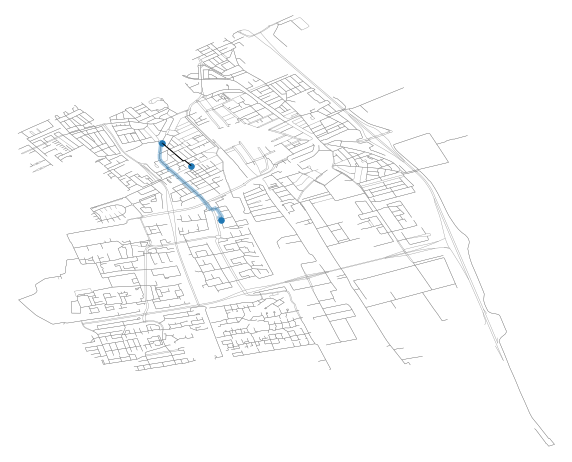

In [19]:
for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()>1:
        break
plot_veh(inData.G, df[df.veh ==2], lw = 1)

-----